In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from aps_ai.beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
from aps_ai.beamline34IDC.optimization import movers, configs, display_utils, common as opt_common
from aps_ai.beamline34IDC.optimization.scipy_nelder_mead import ScipyOptimizer
from aps_ai.beamline34IDC.optimization.skopt_gp import SkoptGaussianProcessOptimizer, SkoptDiscreteGPOptimizer
import beamline34IDC.optimization.movers as movers

from aps_ai.beamline34IDC.optimization.display_utils import LivePlotCallback
from aps_ai.beamline34IDC.util import clean_up
import beamline34IDC
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import IPython
from skopt.callbacks import DeltaXStopper, DeltaYStopper, DeadlineStopper
from pathlib import Path
import optuna

Traceback (most recent call last):
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot.py", line 57, in uti_plot_init
    _backend = uti_plot_matplotlib.Backend(backend, fname_format)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 27, in __init__
    backend = self._init_ipython(backend)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 724, in _init_ipython
    get_ipython().magic('matplotlib ' + b)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2415, in magic
    return self.run_line_magic(magic_name, magic_arg_s, _stack_depth=2)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

Qt5Agg: unable to import specified backend (or its dependency); no plots


In [4]:
%matplotlib inline

In [5]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

64102


In [6]:
!pwd

/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test


In [7]:
base_dir = Path('/'.join(beamline34IDC.__file__.split('/')[:-2]))
orig_work_dir = base_dir /'work_directory'
temp_work_dir = base_dir / f'tmp_work_dir_{DEFAULT_RANDOM_SEED}'
temp_work_dir.mkdir(exist_ok=True)

In [8]:
dat_files = list(orig_work_dir.glob('*.dat')) + list(orig_work_dir.glob('*.ini'))
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [9]:
os.chdir(temp_work_dir)

In [10]:
input_beam_path = "primary_optics_system_beam.dat"

In [11]:
move_motors = ['hkb_1', 'vkb_1', 'hkb_2', 'vkb_2', 'hkb_3', 'vkb_3', 'hkb_4', 'vkb_4']

In [12]:
motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
if not os.path.isdir(fig_save_path):
    os.mkdir(fig_save_path)

In [13]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)

In [14]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, move_motors))
print(initial_absolute_positions)

[215.5 144.  112.5 231.5   3.    3.    0.    0. ]


In [15]:
move_motors_ranges = {'hkb_1': [-30, 30], 
                      'vkb_1': [-30, 30],
                      'hkb_2': [-30, 30],
                      'vkb_2': [-30, 30],
                      'hkb_3': [-0.02, 0.02],
                      'vkb_3': [-0.02, 0.02],
                      'hkb_4': [-20, 20], 
                      'vkb_4': [-20, 20]}

In [16]:
hkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'hkb' in k}

In [17]:
vkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'vkb' in k}

In [70]:
class OptunaOptimizer(opt_common.OptimizationCommon):
    """"""
    opt_platform = 'optuna'

    
    def motor_subset_loss_function(self, motor_types: list, verbose: bool = True):
        lossfn_object_this = self.TrialInstanceLossFunction(self, verbose=verbose)
        
        translations_all = np.zeros(len(self.motor_types))
        
        def closure_fn(translations):
            for ix, motor in enumerate(motor_types):
                iy = self.motor_types.index(motor)
                translations_all[iy] = translations[ix]
            
            return lossfn_object_this.loss(translations_all)
        return closure_fn
    
    def set_optimizer_options(self, motor_ranges: list=None, base_sampler: optuna.samplers.BaseSampler = None, directions: str = None, **extra_options):
        
        self.motor_ranges = self._get_guess_ranges(motor_ranges)
        
        if base_sampler is None:
            if self.multi_objective_optimization:
                base_sampler = optuna.samplers.MOTPESampler()
            else:
                base_sampler = optuna.samplers.TPESampler()
        self._base_sampler = base_sampler
        
        if directions is None:
            directions = ['minimize'] * len(self._loss_function_list)
        elif len(directions) != len(self._loss_function_list):
            raise ValueError
        self._directions = directions
        
        self.study = optuna.create_study(sampler=self._base_sampler, directions=self._directions)
        self.study.enqueue_trial({mt: 0. for mt in self.motor_types})
        
        loss_fn_obj = self.TrialInstanceLossFunction(self, verbose=False)
        self._loss_fn_this = loss_fn_obj.loss
        
        self.best_params = {k: 0. for k in self.motor_types}
    
    def _objective(self, trial):
        current_params = []
        for mot, r in zip(self.motor_types, self.motor_ranges):
            resolution = configs.DEFAULT_MOTOR_RESOLUTIONS[mot]
            #print(mot, 'Min, max, resolution', r[0], r[1], resolution)
            current_params.append(trial.suggest_float(mot, r[0], r[1], step=resolution))
        loss = self._loss_fn_this(current_params)
        
        return loss
    
    def trials(self, n_trials: int, trial_motor_types: list = None):
        if trial_motor_types is None:
            self.study.optimize(self._objective, n_trials)
            
        else:
            
            fixed_params = {k: self.best_params[k] for k in self.best_params if k not in trial_motor_types}
            partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
            
            self.study.sampler = partial_sampler
            self.study.optimize(self._objective, n_trials=n_trials)
            
            self.study.sampler = self._base_sampler
        
        self.best_params.update(self.study.best_trials[0].params)
    
    #def trials(self, n_guesses = 1, verbose: bool = False, accept_all_solutions: bool = False):
    #    pass
    
    def _optimize(self):
        pass

    #def set_optimizer_options(self):
    #    pass
    

In [62]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is ['hkb_1', 'vkb_1', 'hkb_2', 'vkb_2', 'hkb_3', 'vkb_3', 'hkb_4', 'vkb_4'] [22.30629820987469, 21.240446594408994, 9.788799316026058, 14.89021632149057, -0.008626325362287562, 0.012940907461970633, 2.747888080800635, -17.3766843784221]


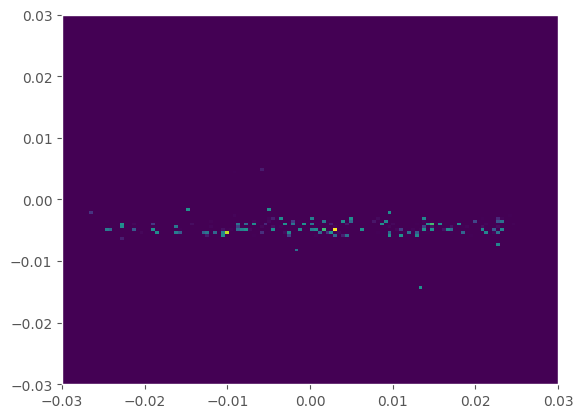

In [63]:
initial_movement, focusing_system, beam, hist, dw = opt_common.get_random_init(focusing_system, move_motors, xrange=[-0.03, 0.03],yrange=[-0.03,0.03], nbins=128)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D)
plt.show()

In [89]:
focusing_system = movers.move_motors(focusing_system, move_motors, initial_absolute_positions + initial_movement, movement='absolute')

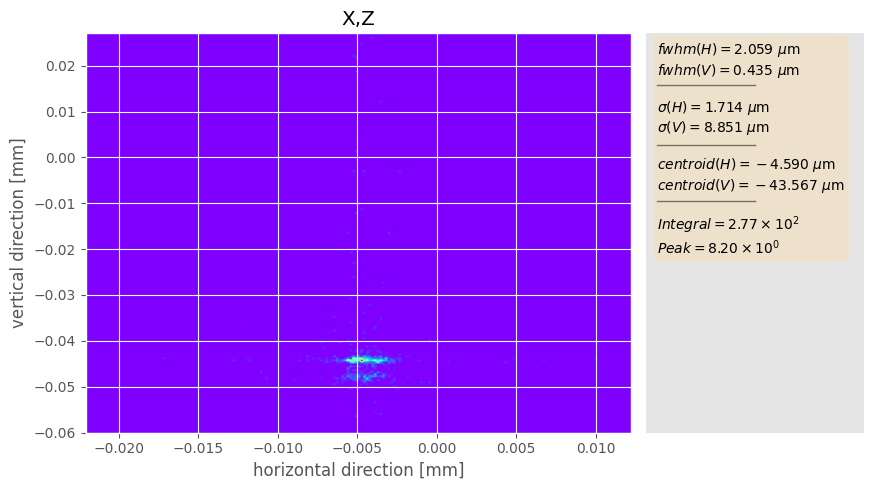

In [90]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)

In [91]:
centroid_motors = ['hkb_3', 'vkb_3', 'hkb_4', 'vkb_4']
centroid_ranges = [move_motors_ranges[m] for m in centroid_motors]

In [92]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=centroid_motors, 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False)
                            #camera_xrange=[-0.03, 0.03],
                            #camera_yrange=[-0.03, 0.03],
                            #camera_nbins=512)
#opt_trial.motor_ranges = centroid_ranges

In [93]:
opt_trial.reset()

In [94]:
opt_trial.set_optimizer_options(motor_ranges=centroid_ranges)

[I 2022-09-21 23:20:18,896] A new study created in memory with name: no-name-e0b71a16-98f9-44d6-89e9-43cfd775c71b


In [95]:
opt_trial.trials(100)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.02, 0.02] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.02, 0.01839724354387525].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hkb_3' with value 0.0 is out of range for distribution FloatDistribution(high=0.01839724354387525, log=False, low=-0.02, step=0.0017453292519943296).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'vkb_3' with value 0.0 is out of range for distribution FloatDistribution(high=0.01839724354387525, log=False, low=-0.02, step=0.0017453292519943296).
  warnings.warn(
[I

In [96]:
current_params = []
for mot in opt_trial.motor_types:
    current_params.append(opt_trial.best_params[mot])
opt_trial._loss_fn_this(current_params)

0.0006932672531780332

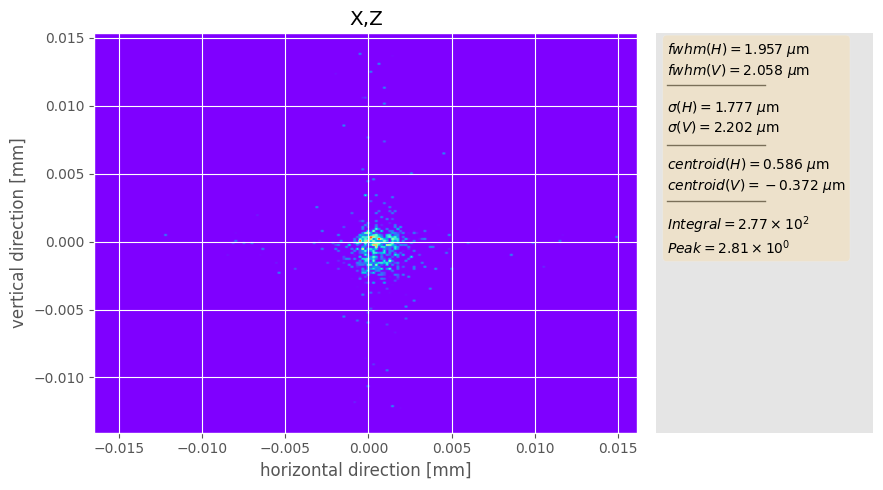

In [97]:
plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_27822/3252744617.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)


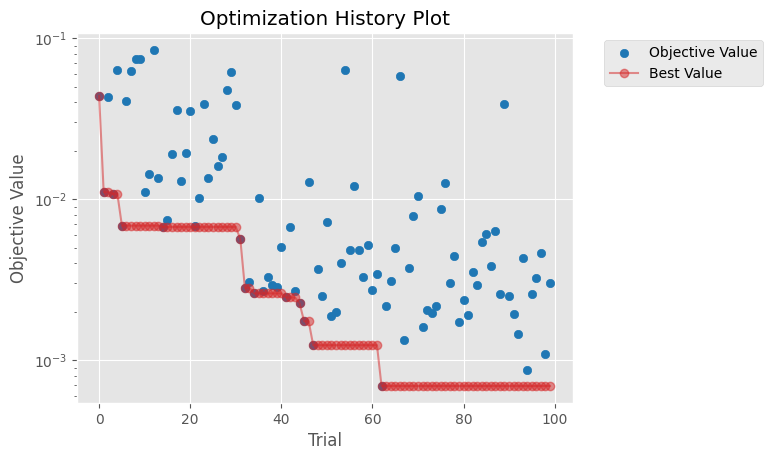

In [98]:
optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)
plt.yscale('log')

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_27822/1592859794.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(opt_trial.study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

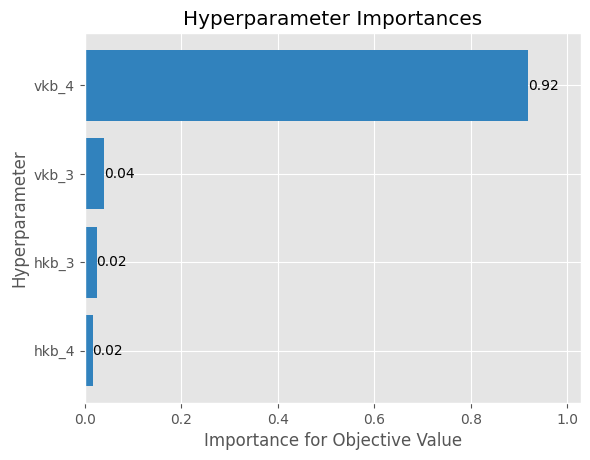

In [99]:
optuna.visualization.matplotlib.plot_param_importances(opt_trial.study)

In [100]:
sigma_motors = ['hkb_1', 'vkb_1', 'hkb_2', 'vkb_2']
sigma_ranges = [move_motors_ranges[m] for m in sigma_motors]

In [101]:
opt_trial2 = OptunaOptimizer(focusing_system, 
                            motor_types=sigma_motors, 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False)
                            #camera_xrange=[-0.03, 0.03],
                            #camera_yrange=[-0.03, 0.03],
                            #camera_nbins=512)

In [102]:
opt_trial2.set_optimizer_options(motor_ranges=sigma_ranges)

[I 2022-09-21 23:23:08,822] A new study created in memory with name: no-name-8c2f3328-7eb7-44da-8f7c-12cde043e5a9


In [103]:
opt_trial2.trials(100)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
[I 2022-09-21 23:23:16,111] Trial 0 finished with value: 0.00283217952030316 and parameters: {'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0}. Best is trial 0 with value: 0.00283217952030316.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:17,173] Trial 1 finished with value: 0.0029107864409214064 and parameters: {'hkb_1': -15.356300000000001, 'vkb_1': -19.552, 'hkb_2': -29.628, 'vkb_2': 27.103699999999996}. Best is trial 0 with value: 0.00283217952030316.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:18,214] Trial 2 finished with value: 0.0028680586377878583 and parameters: {'hkb_1': -15.618000000000002, 'vkb_1': 7.676699999999997, 'hkb_2': 10.687099999999994, 'vkb_2': -21.750799999999998}. Best is trial 0 with value: 0.00283217952030316.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:19,473] Trial 3 finished with value: 0.003209848271895912 and parameters: {'hkb_1': 12.5124, 'vkb_1': 27.115099999999998, 'hkb_2': 14.772599999999997, 'vkb_2': -18.927}. Best is trial 0 with value: 0.00283217952030316.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:20,640] Trial 4 finished with value: 0.002901865742360966 and parameters: {'hkb_1': 2.3495999999999952, 'vkb_1': 7.954899999999995, 'hkb_2': 19.595399999999998, 'vkb_2': -25.989}. Best is trial 0 with value: 0.00283217952030316.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:21,809] Trial 5 finished with value: 0.0027845194820865036 and parameters: {'hkb_1': 7.070899999999995, 'vkb_1': -18.5727, 'hkb_2': 1.6397999999999975, 'vkb_2': 11.6466}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:22,884] Trial 6 finished with value: 0.0032724722203594896 and parameters: {'hkb_1': -27.6331, 'vkb_1': 29.063399999999994, 'hkb_2': 15.336899999999993, 'vkb_2': -0.13970000000000127}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:23,934] Trial 7 finished with value: 0.0031904901927688003 and parameters: {'hkb_1': -23.2078, 'vkb_1': 22.039899999999996, 'hkb_2': -18.570100000000004, 'vkb_2': -1.506300000000003}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:25,095] Trial 8 finished with value: 0.0032061641058064873 and parameters: {'hkb_1': -15.886400000000002, 'vkb_1': 22.0753, 'hkb_2': 24.130499999999998, 'vkb_2': 13.486699999999999}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:26,179] Trial 9 finished with value: 0.0031372277709518976 and parameters: {'hkb_1': 0.3200999999999965, 'vkb_1': 8.888499999999993, 'hkb_2': -22.4667, 'vkb_2': 28.996399999999994}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:27,690] Trial 10 finished with value: 0.002936332481404951 and parameters: {'hkb_1': 27.131499999999996, 'vkb_1': -27.1459, 'hkb_2': -5.649300000000004, 'vkb_2': 11.994799999999998}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:28,951] Trial 11 finished with value: 0.0028214020950006005 and parameters: {'hkb_1': 13.344999999999999, 'vkb_1': -9.969100000000001, 'hkb_2': -0.1968000000000032, 'vkb_2': -9.210600000000003}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:30,225] Trial 12 finished with value: 0.002824532600468231 and parameters: {'hkb_1': 14.396499999999996, 'vkb_1': -14.568800000000001, 'hkb_2': -1.0659000000000027, 'vkb_2': -11.051100000000002}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:31,588] Trial 13 finished with value: 0.0028545789321160818 and parameters: {'hkb_1': 14.605199999999996, 'vkb_1': -9.698600000000003, 'hkb_2': -8.941000000000003, 'vkb_2': 13.177399999999999}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:33,144] Trial 14 finished with value: 0.0030116813889363376 and parameters: {'hkb_1': 29.351099999999995, 'vkb_1': -8.031100000000002, 'hkb_2': 6.631, 'vkb_2': -12.823700000000002}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:34,345] Trial 15 finished with value: 0.0027919141069398215 and parameters: {'hkb_1': 8.533899999999996, 'vkb_1': -25.4511, 'hkb_2': -13.803600000000003, 'vkb_2': 4.5652999999999935}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:35,494] Trial 16 finished with value: 0.0028026565062226894 and parameters: {'hkb_1': 5.4842999999999975, 'vkb_1': -29.9958, 'hkb_2': -12.9329, 'vkb_2': 21.169399999999996}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:36,552] Trial 17 finished with value: 0.0027850110286275743 and parameters: {'hkb_1': -5.592700000000001, 'vkb_1': -22.157, 'hkb_2': -14.776600000000002, 'vkb_2': 5.552199999999999}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:37,786] Trial 18 finished with value: 0.0027964687299711754 and parameters: {'hkb_1': -8.338600000000003, 'vkb_1': -20.6806, 'hkb_2': 29.582399999999993, 'vkb_2': 7.7416999999999945}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:38,854] Trial 19 finished with value: 0.0028837557587843466 and parameters: {'hkb_1': -9.334800000000001, 'vkb_1': -2.0823000000000036, 'hkb_2': 5.511599999999994, 'vkb_2': 19.871999999999993}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:39,908] Trial 20 finished with value: 0.002832842783759941 and parameters: {'hkb_1': -6.981800000000003, 'vkb_1': -20.4542, 'hkb_2': -21.768900000000002, 'vkb_2': 20.6637}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:41,068] Trial 21 finished with value: 0.0027845644990951365 and parameters: {'hkb_1': 6.601799999999997, 'vkb_1': -24.6627, 'hkb_2': -14.634300000000001, 'vkb_2': 6.042499999999997}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:42,437] Trial 22 finished with value: 0.0028647788306084892 and parameters: {'hkb_1': 20.122199999999992, 'vkb_1': -15.840200000000001, 'hkb_2': -28.7015, 'vkb_2': 6.218199999999996}. Best is trial 5 with value: 0.0027845194820865036.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:43,503] Trial 23 finished with value: 0.0027765930599500696 and parameters: {'hkb_1': -3.1967000000000034, 'vkb_1': -23.7785, 'hkb_2': -5.668900000000001, 'vkb_2': -4.880000000000003}. Best is trial 23 with value: 0.0027765930599500696.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:44,679] Trial 24 finished with value: 0.0027788036349622905 and parameters: {'hkb_1': 7.017699999999998, 'vkb_1': -15.075500000000002, 'hkb_2': -5.607800000000001, 'vkb_2': -5.397500000000001}. Best is trial 23 with value: 0.0027765930599500696.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:46,103] Trial 25 finished with value: 0.002874935753312483 and parameters: {'hkb_1': 21.906399999999998, 'vkb_1': -17.090700000000002, 'hkb_2': -6.302600000000002, 'vkb_2': -6.731700000000004}. Best is trial 23 with value: 0.0027765930599500696.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:47,183] Trial 26 finished with value: 0.0027878741769754418 and parameters: {'hkb_1': -4.122500000000002, 'vkb_1': -5.189200000000003, 'hkb_2': 2.607699999999994, 'vkb_2': -5.546400000000002}. Best is trial 23 with value: 0.0027765930599500696.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:48,311] Trial 27 finished with value: 0.002787374833855839 and parameters: {'hkb_1': 3.8903999999999996, 'vkb_1': -13.3853, 'hkb_2': -5.279200000000003, 'vkb_2': -15.803}. Best is trial 23 with value: 0.0027765930599500696.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:49,361] Trial 28 finished with value: 0.0028574522113150986 and parameters: {'hkb_1': -2.834000000000003, 'vkb_1': 3.7154999999999987, 'hkb_2': 7.893599999999999, 'vkb_2': -2.5096000000000025}. Best is trial 23 with value: 0.0027765930599500696.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:50,581] Trial 29 finished with value: 0.002804750846803526 and parameters: {'hkb_1': 9.556599999999996, 'vkb_1': -29.7732, 'hkb_2': -2.652000000000001, 'vkb_2': 1.7977999999999987}. Best is trial 23 with value: 0.0027765930599500696.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:51,953] Trial 30 finished with value: 0.002851231285705339 and parameters: {'hkb_1': 19.165999999999997, 'vkb_1': -11.551000000000002, 'hkb_2': -9.624100000000002, 'vkb_2': -4.3709000000000024}. Best is trial 23 with value: 0.0027765930599500696.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:53,215] Trial 31 finished with value: 0.002786967027387586 and parameters: {'hkb_1': 7.9254999999999995, 'vkb_1': -24.691200000000002, 'hkb_2': -10.985400000000002, 'vkb_2': 9.508899999999997}. Best is trial 23 with value: 0.0027765930599500696.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:54,317] Trial 32 finished with value: 0.0027921509236478706 and parameters: {'hkb_1': -0.4592000000000027, 'vkb_1': -23.6839, 'hkb_2': -18.4846, 'vkb_2': 2.1751000000000005}. Best is trial 23 with value: 0.0027765930599500696.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:55,398] Trial 33 finished with value: 0.0027734590022857556 and parameters: {'hkb_1': -11.160700000000002, 'vkb_1': -18.854300000000002, 'hkb_2': 3.6402999999999963, 'vkb_2': 17.661299999999997}. Best is trial 33 with value: 0.0027734590022857556.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:56,458] Trial 34 finished with value: 0.002810426367778075 and parameters: {'hkb_1': -12.950000000000003, 'vkb_1': -18.15, 'hkb_2': 2.278499999999994, 'vkb_2': 25.658499999999997}. Best is trial 33 with value: 0.0027734590022857556.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:57,521] Trial 35 finished with value: 0.002844150281401917 and parameters: {'hkb_1': -12.459200000000003, 'vkb_1': -3.615400000000001, 'hkb_2': 12.740799999999993, 'vkb_2': 14.906899999999993}. Best is trial 33 with value: 0.0027734590022857556.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:58,592] Trial 36 finished with value: 0.0027830821227485757 and parameters: {'hkb_1': -17.3747, 'vkb_1': -18.1887, 'hkb_2': 2.5723999999999947, 'vkb_2': 16.905199999999994}. Best is trial 33 with value: 0.0027734590022857556.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:23:59,653] Trial 37 finished with value: 0.0028054778245986353 and parameters: {'hkb_1': -19.6365, 'vkb_1': -14.939100000000002, 'hkb_2': 9.4165, 'vkb_2': -22.9388}. Best is trial 33 with value: 0.0027734590022857556.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:00,765] Trial 38 finished with value: 0.002848052918383257 and parameters: {'hkb_1': -20.876600000000003, 'vkb_1': -6.429600000000001, 'hkb_2': 4.8339, 'vkb_2': 17.6348}. Best is trial 33 with value: 0.0027734590022857556.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:01,831] Trial 39 finished with value: 0.002990563821412844 and parameters: {'hkb_1': -16.561500000000002, 'vkb_1': 1.8673999999999964, 'hkb_2': -3.1042000000000023, 'vkb_2': 25.75359999999999}. Best is trial 33 with value: 0.0027734590022857556.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:02,939] Trial 40 finished with value: 0.0029205014841302166 and parameters: {'hkb_1': -24.5153, 'vkb_1': 12.072499999999998, 'hkb_2': 17.064099999999996, 'vkb_2': -16.3264}. Best is trial 33 with value: 0.0027734590022857556.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:04,036] Trial 41 finished with value: 0.002772852287787007 and parameters: {'hkb_1': 0.7503999999999991, 'vkb_1': -20.1824, 'hkb_2': 2.427099999999996, 'vkb_2': 15.901999999999994}. Best is trial 41 with value: 0.002772852287787007.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:05,094] Trial 42 finished with value: 0.002764490331698338 and parameters: {'hkb_1': -10.953700000000001, 'vkb_1': -20.4695, 'hkb_2': 3.609199999999994, 'vkb_2': 16.248599999999996}. Best is trial 42 with value: 0.002764490331698338.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:06,207] Trial 43 finished with value: 0.002796170545932642 and parameters: {'hkb_1': 0.809199999999997, 'vkb_1': -21.7924, 'hkb_2': 11.080099999999995, 'vkb_2': 23.022299999999994}. Best is trial 42 with value: 0.002764490331698338.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:07,263] Trial 44 finished with value: 0.0027724648296041 and parameters: {'hkb_1': -11.613900000000001, 'vkb_1': -27.9961, 'hkb_2': -3.491500000000002, 'vkb_2': 10.538399999999996}. Best is trial 42 with value: 0.002764490331698338.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:08,341] Trial 45 finished with value: 0.0027638843107958165 and parameters: {'hkb_1': -10.249100000000002, 'vkb_1': -27.3169, 'hkb_2': -1.0781000000000027, 'vkb_2': 9.612299999999998}. Best is trial 45 with value: 0.0027638843107958165.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:09,519] Trial 46 finished with value: 0.002765306414714236 and parameters: {'hkb_1': -11.002100000000002, 'vkb_1': -28.6357, 'hkb_2': 0.4187999999999974, 'vkb_2': 10.215699999999998}. Best is trial 45 with value: 0.0027638843107958165.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:10,578] Trial 47 finished with value: 0.0027708559858216 and parameters: {'hkb_1': -13.305800000000001, 'vkb_1': -27.9835, 'hkb_2': -0.10730000000000217, 'vkb_2': 11.430699999999995}. Best is trial 45 with value: 0.0027638843107958165.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:11,667] Trial 48 finished with value: 0.0027678035852333697 and parameters: {'hkb_1': -14.4882, 'vkb_1': -28.4437, 'hkb_2': 0.06869999999999621, 'vkb_2': 10.265199999999993}. Best is trial 45 with value: 0.0027638843107958165.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:12,716] Trial 49 finished with value: 0.0027681678290207077 and parameters: {'hkb_1': -13.8294, 'vkb_1': -26.8661, 'hkb_2': 0.5342999999999982, 'vkb_2': 8.770499999999998}. Best is trial 45 with value: 0.0027638843107958165.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:13,794] Trial 50 finished with value: 0.0027796993951419665 and parameters: {'hkb_1': -24.6535, 'vkb_1': -27.0186, 'hkb_2': 7.773399999999995, 'vkb_2': 9.112899999999996}. Best is trial 45 with value: 0.0027638843107958165.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:14,848] Trial 51 finished with value: 0.002769319634807307 and parameters: {'hkb_1': -14.269800000000002, 'vkb_1': -27.4708, 'hkb_2': -0.26190000000000424, 'vkb_2': 11.606699999999996}. Best is trial 45 with value: 0.0027638843107958165.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:15,902] Trial 52 finished with value: 0.002784518453149185 and parameters: {'hkb_1': -19.056400000000004, 'vkb_1': -29.8454, 'hkb_2': -0.7273000000000032, 'vkb_2': 13.600499999999997}. Best is trial 45 with value: 0.0027638843107958165.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:16,962] Trial 53 finished with value: 0.0027661973115251396 and parameters: {'hkb_1': -14.577700000000002, 'vkb_1': -26.4805, 'hkb_2': 0.39459999999999695, 'vkb_2': 3.3862999999999985}. Best is trial 45 with value: 0.0027638843107958165.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:18,012] Trial 54 finished with value: 0.0027592283279333886 and parameters: {'hkb_1': -9.573900000000002, 'vkb_1': -26.0302, 'hkb_2': 5.1325, 'vkb_2': 3.199299999999994}. Best is trial 54 with value: 0.0027592283279333886.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:19,073] Trial 55 finished with value: 0.002757916745281589 and parameters: {'hkb_1': -10.058800000000002, 'vkb_1': -25.4683, 'hkb_2': 5.352399999999996, 'vkb_2': 2.5381}. Best is trial 55 with value: 0.002757916745281589.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:20,130] Trial 56 finished with value: 0.0027501128097159526 and parameters: {'hkb_1': -9.112800000000004, 'vkb_1': -22.8234, 'hkb_2': 6.015699999999995, 'vkb_2': 2.8566000000000003}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:21,218] Trial 57 finished with value: 0.0027550494444323467 and parameters: {'hkb_1': -9.462900000000001, 'vkb_1': -23.1442, 'hkb_2': 11.822599999999994, 'vkb_2': 0.1336999999999975}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:22,375] Trial 58 finished with value: 0.0027659332686360586 and parameters: {'hkb_1': -8.192800000000002, 'vkb_1': -22.269000000000002, 'hkb_2': 19.293899999999994, 'vkb_2': -2.789800000000003}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:23,446] Trial 59 finished with value: 0.002765077261149595 and parameters: {'hkb_1': -5.684700000000003, 'vkb_1': -22.613300000000002, 'hkb_2': 14.642699999999998, 'vkb_2': 2.005199999999995}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:24,502] Trial 60 finished with value: 0.0029909614769686914 and parameters: {'hkb_1': -9.661700000000003, 'vkb_1': 14.873999999999995, 'hkb_2': 10.584599999999995, 'vkb_2': -0.4859000000000009}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:25,571] Trial 61 finished with value: 0.0027652110800928656 and parameters: {'hkb_1': -5.722300000000001, 'vkb_1': -22.038800000000002, 'hkb_2': 13.971499999999999, 'vkb_2': 1.3319999999999972}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:26,681] Trial 62 finished with value: 0.002764010630158649 and parameters: {'hkb_1': -6.306600000000003, 'vkb_1': -23.8005, 'hkb_2': 16.6652, 'vkb_2': 4.130499999999998}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:27,851] Trial 63 finished with value: 0.002788468571353713 and parameters: {'hkb_1': -2.195300000000003, 'vkb_1': -25.5548, 'hkb_2': 23.566599999999994, 'vkb_2': 6.9437}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:28,953] Trial 64 finished with value: 0.002763215284817501 and parameters: {'hkb_1': -7.6773000000000025, 'vkb_1': -24.3488, 'hkb_2': 17.475299999999997, 'vkb_2': 3.949799999999996}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:30,179] Trial 65 finished with value: 0.0027712930985526636 and parameters: {'hkb_1': -7.490300000000001, 'vkb_1': -24.5824, 'hkb_2': 21.742499999999993, 'vkb_2': 4.6417}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:31,298] Trial 66 finished with value: 0.0027668086291182644 and parameters: {'hkb_1': -5.274600000000003, 'vkb_1': -16.4917, 'hkb_2': 18.229599999999998, 'vkb_2': -0.3119000000000014}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:32,381] Trial 67 finished with value: 0.002763568707924013 and parameters: {'hkb_1': -8.8641, 'vkb_1': -13.107100000000003, 'hkb_2': 15.987199999999994, 'vkb_2': 3.9913999999999987}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:33,459] Trial 68 finished with value: 0.002763825764260259 and parameters: {'hkb_1': -8.831100000000003, 'vkb_1': -12.171700000000001, 'hkb_2': 12.037099999999995, 'vkb_2': -1.6802000000000028}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:34,530] Trial 69 finished with value: 0.0027668731066475393 and parameters: {'hkb_1': -8.481300000000001, 'vkb_1': -9.187900000000003, 'hkb_2': 11.831399999999995, 'vkb_2': -7.7448000000000015}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:35,607] Trial 70 finished with value: 0.002823663683140092 and parameters: {'hkb_1': -1.205400000000001, 'vkb_1': -0.6179000000000023, 'hkb_2': 9.054899999999996, 'vkb_2': -2.0222000000000016}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:36,687] Trial 71 finished with value: 0.00275229840901307 and parameters: {'hkb_1': -9.721600000000002, 'vkb_1': -18.907600000000002, 'hkb_2': 6.550799999999995, 'vkb_2': 7.480199999999996}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:37,748] Trial 72 finished with value: 0.0027633113615025836 and parameters: {'hkb_1': -4.188600000000001, 'vkb_1': -12.6659, 'hkb_2': 6.623799999999996, 'vkb_2': 0.5631999999999984}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:38,799] Trial 73 finished with value: 0.002756283344668552 and parameters: {'hkb_1': -4.240800000000004, 'vkb_1': -17.4583, 'hkb_2': 6.394299999999994, 'vkb_2': 6.688299999999998}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:39,875] Trial 74 finished with value: 0.0027551579288288912 and parameters: {'hkb_1': -3.880200000000002, 'vkb_1': -18.436700000000002, 'hkb_2': 6.407499999999999, 'vkb_2': 6.838099999999997}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:41,007] Trial 75 finished with value: 0.0027625890143883397 and parameters: {'hkb_1': 3.053999999999995, 'vkb_1': -17.8212, 'hkb_2': 5.5167, 'vkb_2': 7.111999999999995}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:42,121] Trial 76 finished with value: 0.002764775192557998 and parameters: {'hkb_1': 2.7258999999999958, 'vkb_1': -17.658500000000004, 'hkb_2': 5.517099999999999, 'vkb_2': 7.5785999999999945}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:43,274] Trial 77 finished with value: 0.0027691620796114896 and parameters: {'hkb_1': 4.726699999999994, 'vkb_1': -19.248600000000003, 'hkb_2': 7.096199999999996, 'vkb_2': 6.159099999999995}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:44,502] Trial 78 finished with value: 0.0028094526303437247 and parameters: {'hkb_1': 10.812599999999996, 'vkb_1': -14.9556, 'hkb_2': 9.026499999999999, 'vkb_2': 2.5989000000000004}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:45,561] Trial 79 finished with value: 0.0027612182462768897 and parameters: {'hkb_1': -4.0832000000000015, 'vkb_1': -20.837400000000002, 'hkb_2': 4.801299999999998, 'vkb_2': -3.785300000000003}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:46,710] Trial 80 finished with value: 0.002770712547899608 and parameters: {'hkb_1': -3.3347000000000016, 'vkb_1': -21.169400000000003, 'hkb_2': 4.189499999999995, 'vkb_2': -9.921300000000002}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:47,828] Trial 81 finished with value: 0.002762264613899795 and parameters: {'hkb_1': 1.7624999999999957, 'vkb_1': -18.8075, 'hkb_2': 5.7654, 'vkb_2': -3.310100000000002}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:48,947] Trial 82 finished with value: 0.002765572393693067 and parameters: {'hkb_1': -0.8424000000000014, 'vkb_1': -19.2187, 'hkb_2': 9.433799999999998, 'vkb_2': -3.4958000000000027}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:50,053] Trial 83 finished with value: 0.002764125895291021 and parameters: {'hkb_1': 1.4553999999999974, 'vkb_1': -16.5124, 'hkb_2': 6.184799999999996, 'vkb_2': -6.1187000000000005}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:51,124] Trial 84 finished with value: 0.002755810370431752 and parameters: {'hkb_1': -3.837200000000003, 'vkb_1': -22.8443, 'hkb_2': 4.103699999999996, 'vkb_2': 5.390499999999996}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:52,180] Trial 85 finished with value: 0.0027598582742296464 and parameters: {'hkb_1': -4.0146000000000015, 'vkb_1': -22.7967, 'hkb_2': 4.395699999999998, 'vkb_2': 0.454699999999999}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:53,281] Trial 86 finished with value: 0.0027687574579551752 and parameters: {'hkb_1': -1.8625000000000007, 'vkb_1': -22.8778, 'hkb_2': 13.425999999999995, 'vkb_2': 5.621699999999997}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:54,335] Trial 87 finished with value: 0.0027650206673563433 and parameters: {'hkb_1': -4.383800000000001, 'vkb_1': -25.9821, 'hkb_2': 8.328399999999995, 'vkb_2': 0.021999999999998465}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:55,389] Trial 88 finished with value: 0.003200058527593243 and parameters: {'hkb_1': -12.386000000000003, 'vkb_1': 24.533499999999997, 'hkb_2': 1.7962999999999987, 'vkb_2': 5.084199999999996}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:56,454] Trial 89 finished with value: 0.002753095772150347 and parameters: {'hkb_1': -10.755400000000002, 'vkb_1': -25.4505, 'hkb_2': 3.6913999999999945, 'vkb_2': 8.591299999999997}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:57,550] Trial 90 finished with value: 0.0027701515339248863 and parameters: {'hkb_1': -17.341, 'vkb_1': -25.3493, 'hkb_2': 2.969999999999999, 'vkb_2': 12.976399999999998}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:58,613] Trial 91 finished with value: 0.00275018677343759 and parameters: {'hkb_1': -10.1004, 'vkb_1': -23.217200000000002, 'hkb_2': 7.391999999999996, 'vkb_2': 8.707699999999996}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:24:59,693] Trial 92 finished with value: 0.0027535803761973817 and parameters: {'hkb_1': -7.194200000000002, 'vkb_1': -23.7363, 'hkb_2': 9.917299999999997, 'vkb_2': 8.022499999999994}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:25:00,751] Trial 93 finished with value: 0.0027550495651812506 and parameters: {'hkb_1': -15.9722, 'vkb_1': -20.0594, 'hkb_2': 10.722499999999997, 'vkb_2': 8.082999999999998}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:25:01,811] Trial 94 finished with value: 0.0027524154839367997 and parameters: {'hkb_1': -15.6598, 'vkb_1': -21.514200000000002, 'hkb_2': 10.671, 'vkb_2': 8.521499999999996}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:25:02,872] Trial 95 finished with value: 0.002758201188528959 and parameters: {'hkb_1': -15.742300000000002, 'vkb_1': -20.056800000000003, 'hkb_2': 9.8005, 'vkb_2': 7.797499999999999}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:25:03,943] Trial 96 finished with value: 0.002761856457370051 and parameters: {'hkb_1': -18.442, 'vkb_1': -23.307000000000002, 'hkb_2': 12.729999999999997, 'vkb_2': 14.496299999999998}. Best is trial 56 with value: 0.0027501128097159526.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:25:05,000] Trial 97 finished with value: 0.0027481318809126722 and parameters: {'hkb_1': -12.688000000000002, 'vkb_1': -21.2063, 'hkb_2': 10.813099999999999, 'vkb_2': 8.348399999999998}. Best is trial 97 with value: 0.0027481318809126722.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:25:06,139] Trial 98 finished with value: 0.002749721759976456 and parameters: {'hkb_1': -11.9647, 'vkb_1': -21.3673, 'hkb_2': 10.578199999999995, 'vkb_2': 8.580199999999998}. Best is trial 97 with value: 0.0027481318809126722.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-21 23:25:07,190] Trial 99 finished with value: 0.0027634483045942395 and parameters: {'hkb_1': -22.1689, 'vkb_1': -21.184800000000003, 'hkb_2': 10.683299999999996, 'vkb_2': 8.293499999999995}. Best is trial 97 with value: 0.0027481318809126722.


In [104]:
current_params = []
for mot in opt_trial2.motor_types:
    current_params.append(opt_trial2.best_params[mot])
opt_trial2._loss_fn_this(current_params)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


0.0027482406207591766

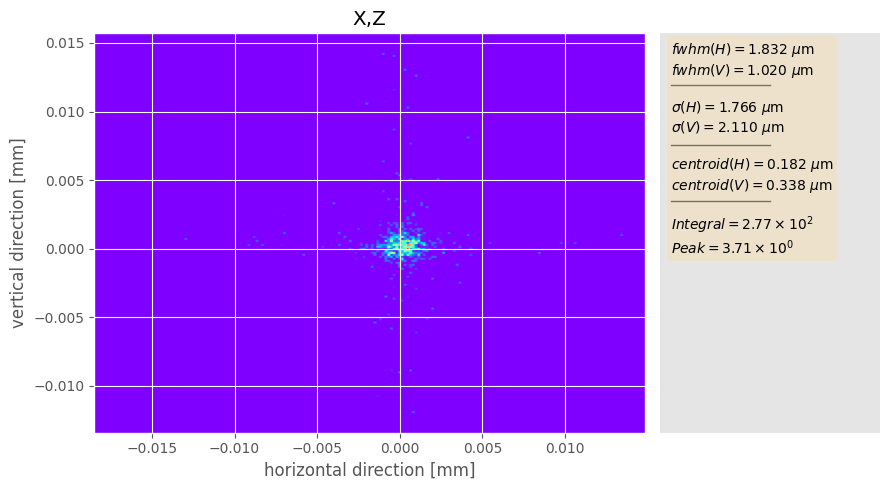

In [105]:
plot_shadow_beam_spatial_distribution(opt_trial2.beam_state.photon_beam, xrange=opt_trial2._camera_xrange, yrange=opt_trial2._camera_yrange)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_27822/892849071.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(opt_trial2.study)


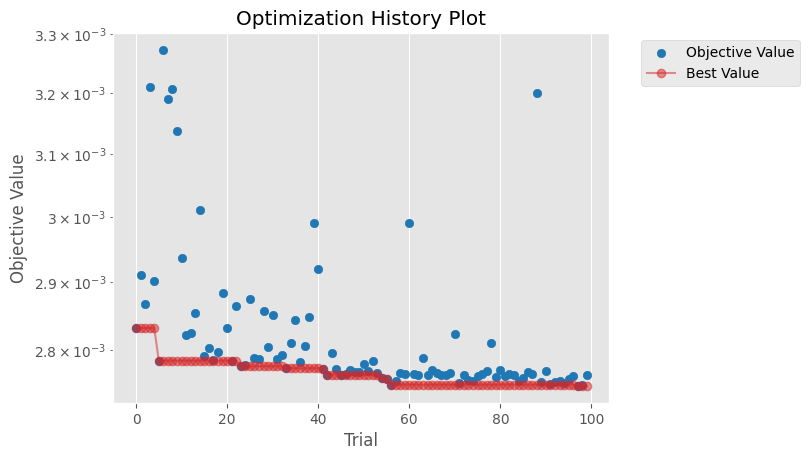

In [106]:
optuna.visualization.matplotlib.plot_optimization_history(opt_trial2.study)
plt.yscale('log')

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_27822/654660056.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(opt_trial2.study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

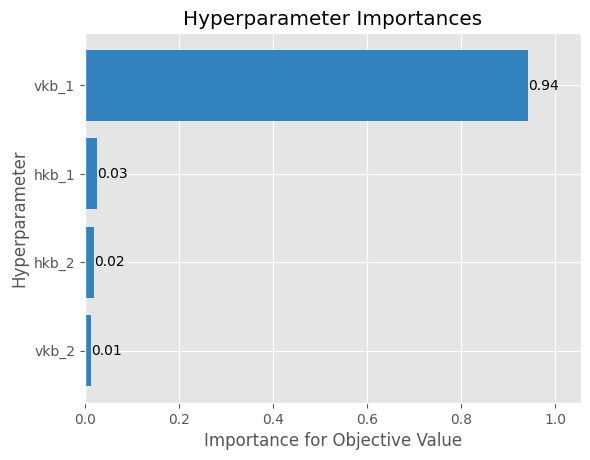

In [107]:
optuna.visualization.matplotlib.plot_param_importances(opt_trial2.study)

In [108]:
opt_trial3 = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['sigma', 'centroid'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            camera_xrange=[-0.03, 0.03],
                            camera_yrange=[-0.03, 0.03],
                            camera_nbins=512,
                            multi_objective_optimization=True)

In [109]:
move_motors_ranges

{'hkb_1': [-30, 30],
 'vkb_1': [-30, 30],
 'hkb_2': [-30, 30],
 'vkb_2': [-30, 30],
 'hkb_3': [-0.02, 0.02],
 'vkb_3': [-0.02, 0.02],
 'hkb_4': [-20, 20],
 'vkb_4': [-20, 20]}

In [110]:
opt_trial3.set_optimizer_options(motor_ranges=list(move_motors_ranges.values()))

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_27822/2984842256.py:25: FutureWarning: MOTPESampler has been deprecated in v2.9.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.9.0.
  base_sampler = optuna.samplers.MOTPESampler()
[I 2022-09-21 23:25:45,781] A new study created in memory with name: no-name-cad9f938-55be-4f46-a3b2-e5966e0fc9db


In [111]:
opt_trial3._directions

['minimize', 'minimize']

In [112]:
opt_trial3._loss_fn_this(np.zeros(8))

array([0.00275023, 0.00038396])

In [113]:
opt_trial3.trials(50)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 30] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-30, 29.999999999999993].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.02, 0.02] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.02, 0.01839724354387525].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hkb_3' with value 0.0 is out of range for distribution FloatDistribution(high=0.01839724354387525, log=False, low=-0.02, step=0.0017453292519943296).
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[W 2022-09-21 23:25:52,413] Trial 1 failed because of the following error: The number of the values 1 did not match the number of the objectives 2.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[W 2022-09-21 23:25:53,927] Trial 2 failed because of the following error: The number of the values 1 did not match the number of the objectives 2.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[W 2022-09-21 23:25:55,723] Trial 3 failed because of the following error: The number of the values 1 did not match the number of the objectives 2.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[W 2022-09-21 23:25:57,598] Trial 4 failed because of the following error: The number of the values 1 did not match the number of the objectives 2.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[W 2022-09-21 23:25:59,099] Trial 5 failed because of the following error: The number of the values 1 did not match the number of the objectives 2.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.


[W 2022-09-21 23:26:00,511] Trial 6 failed because of the following error: The number of the values 1 did not match the number of the objectives 2.


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_VKB_bender_profile.dat written to disk.


[W 2022-09-21 23:26:01,236] Trial 7 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_27822/2984842256.py", line 50, in _objective
    loss = self._loss_fn_this(current_params)
  File "/Users/skandel/code/oasys/ML_Control_System/beamline34IDC/optimization/common.py", line 277, in loss
    self.current_loss = self.opt_common.loss_function(x_relative_this, verbose=False)
  File "/Users/skandel/code/oasys/ML_Control_System/beamline34IDC/optimization/common.py", line 392, in loss_function
    self._update_beam_state()
  File "/Users/skandel/code/oasys/ML_Control_System/beamline34IDC/optimization/common.py", line 353, in _update_beam_state
    current_beam, current_hist, current_dw = ge

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_64102/Downstream_HKB_bender_profile.dat written to disk.



KeyboardInterrupt



### Older stuff

dict_values([0.007753201881758542, 0.01599870183342051, -0.007100292126874085, 0.0016346948157988997])


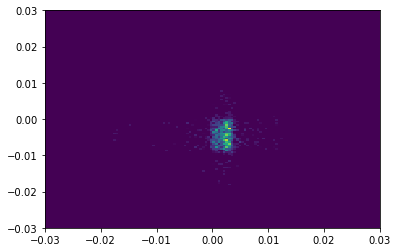

dict_values([0.02599725498457267, 0.002618331686709406, 0.0030446104823436335, 0.005517552335661995])


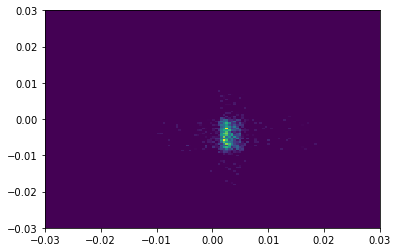

In [145]:
for pars in params:
    opt_trial1._lossfn_this(np.array(list(pars)))
    beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system=focusing_system, random_seed=DEFAULT_RANDOM_SEED, xrange=[-0.03, 0.03], yrange=[-0.03, 0.03], nbins=128)
    print(pars)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D)
    plt.show()

In [146]:
opt_trial1._lossfn_this(np.array(list(params[0])))

[0.004910968075958509, 0.003699596879323574]

In [147]:
opt_trial2 = OptunaOptimizer(focusing_system, 
                             motor_types=list(vkb_motors_ranges.keys()), 
                             random_seed=DEFAULT_RANDOM_SEED, 
                             loss_parameters=['centroid', 'sigma'],
                             loss_min_value=5e-4,
                             use_gaussian_fit=False)
opt_trial2.motor_ranges = np.array(list(vkb_motors_ranges.values()))
opt_trial2._lossfn_obj_this = opt_trial2.TrialInstanceLossFunction(opt_trial2, verbose=False)
opt_trial2._lossfn_this = opt_trial2._lossfn_obj_this.loss

In [148]:
study = optuna.create_study(directions=['minimize', 'minimize'])

[I 2022-09-10 16:26:59,635] A new study created in memory with name: no-name-19fa8990-a002-4b6f-a53c-80f02e349ff8


In [149]:
study.optimize(opt_trial2.objective, n_trials=50)
#study.optimize(opt_trial2.objective, n_trials=10)

[I 2022-09-10 16:27:06,411] Trial 0 finished with values: [0.01017465742964017, 0.005124627521898723] and parameters: {'vkb_1': 0.026140187344013043, 'vkb_2': 0.005361257178602398, 'vkb_3': 0.019150007085297596, 'vkb_4': 0.004292584716299223}. 
[I 2022-09-10 16:27:08,747] Trial 1 finished with values: [0.019942558663392177, 0.004746089219607632] and parameters: {'vkb_1': -0.0026275816161017637, 'vkb_2': 0.0010392821458932201, 'vkb_3': 0.01734884485983253, 'vkb_4': -0.009085415391803728}. 
[I 2022-09-10 16:27:11,004] Trial 2 finished with values: [0.01086148735691517, 0.002982623175695592] and parameters: {'vkb_1': -0.023026795294989005, 'vkb_2': -0.007979819299511654, 'vkb_3': 0.0037840381758191682, 'vkb_4': -0.005328707481490904}. 
[I 2022-09-10 16:27:13,251] Trial 3 finished with values: [0.0025153895465234353, 0.0036048979054867903] and parameters: {'vkb_1': 0.01094928171453146, 'vkb_2': -0.014047506463435794, 'vkb_3': 0.0003826695853460377, 'vkb_4': 0.007704229657310357}. 
[I 2022-

In [150]:
trials = study.best_trials

In [151]:
trials

[FrozenTrial(number=2, values=[0.01086148735691517, 0.002982623175695592], datetime_start=datetime.datetime(2022, 9, 10, 16, 27, 8, 748135), datetime_complete=datetime.datetime(2022, 9, 10, 16, 27, 11, 4370), params={'vkb_1': -0.023026795294989005, 'vkb_2': -0.007979819299511654, 'vkb_3': 0.0037840381758191682, 'vkb_4': -0.005328707481490904}, distributions={'vkb_1': UniformDistribution(high=0.03, low=-0.03), 'vkb_2': UniformDistribution(high=0.03, low=-0.03), 'vkb_3': UniformDistribution(high=0.02, low=-0.02), 'vkb_4': UniformDistribution(high=0.01, low=-0.01)}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, trial_id=2, state=TrialState.COMPLETE, value=None),
 FrozenTrial(number=3, values=[0.0025153895465234353, 0.0036048979054867903], datetime_start=datetime.datetime(2022, 9, 10, 16, 27, 11, 5247), datetime_complete=datetime.datetime(2022, 9, 10, 16, 27, 13, 250933), params={'vkb_1': 0.01094928171453146, 'vkb_2': -0.014047506463435794, 'vkb_3': 0.0003826

In [152]:
xvals = []
yvals = []
idxs = []
params = []
for t in trials:
    xvals.append(t.values[0])
    yvals.append(t.values[1])
    idxs.append(t.number)
    params.append(t.params.values())
    

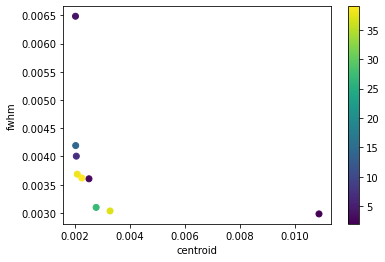

In [153]:
plt.scatter(xvals, yvals, c=idxs)
plt.xlabel('centroid')
plt.ylabel('fwhm')
plt.colorbar()

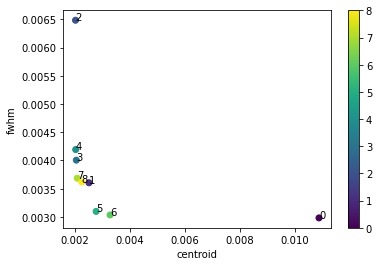

In [158]:
plt.scatter(xvals, yvals, c=np.arange(len(xvals)))
for i in range(len(xvals)):
    plt.annotate(str(i), (xvals[i], yvals[i]))
plt.xlabel('centroid')
plt.ylabel('fwhm')
plt.colorbar()

dict_values([-0.023026795294989005, -0.007979819299511654, 0.0037840381758191682, -0.005328707481490904])


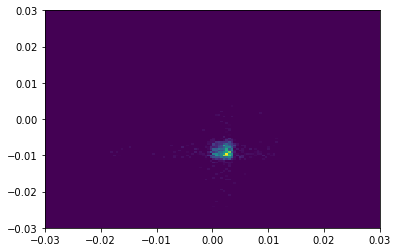

dict_values([0.01094928171453146, -0.014047506463435794, 0.0003826695853460377, 0.007704229657310357])


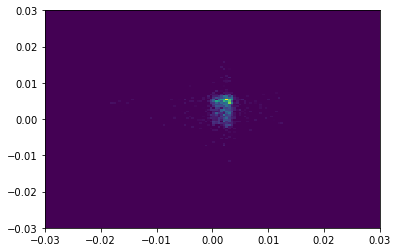

dict_values([-0.007077951280115978, -0.000504362156872603, -0.01723436841359705, -0.0039048642465601534])


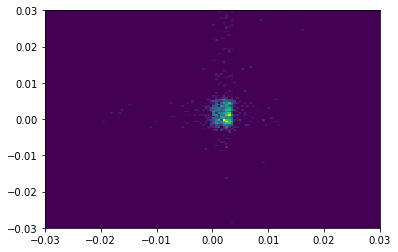

dict_values([-0.011067444529912453, 0.016380890408058867, 0.0004138962611424449, 0.003670693862989672])


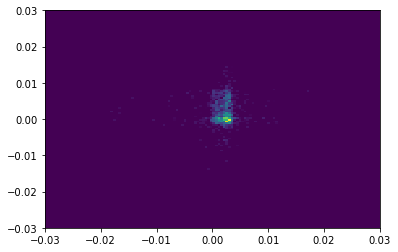

dict_values([-0.013543166546381859, 0.02410090428343438, 0.005679286960128805, 0.004816735691399962])


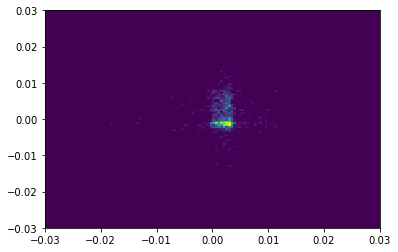

dict_values([-0.018351665131631976, -0.0061397545450877465, -0.004335821994163037, 0.003383309676890706])


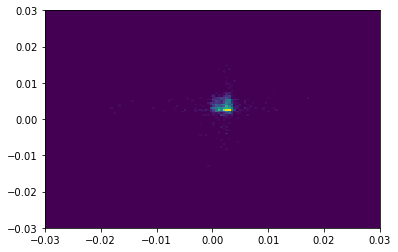

dict_values([-0.006107924564332769, -0.015003565862863166, 0.008062569323242796, 0.005071595585675603])


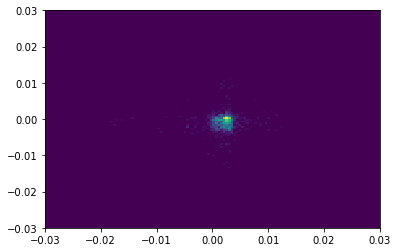

dict_values([-0.02771575421485901, 0.016864160713565328, 0.0033219884736915006, 0.001623201901967554])


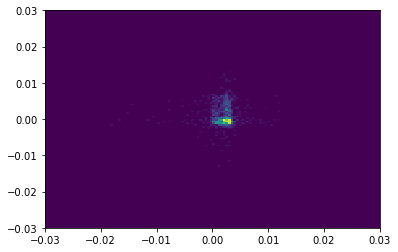

dict_values([0.011048792143387415, -0.012055037060789715, -0.005860600323024165, 0.0030527040539086413])


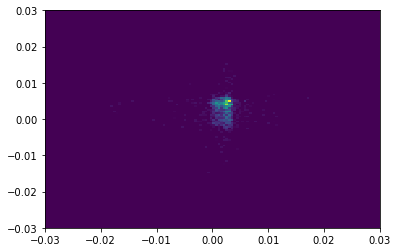

In [155]:
for pars in params:
    opt_trial2._lossfn_this(np.array(list(pars)))
    beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system=focusing_system, random_seed=DEFAULT_RANDOM_SEED, xrange=[-0.03, 0.03], yrange=[-0.03, 0.03], nbins=128)
    print(pars)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D)
    plt.show()

In [159]:
opt_trial2._lossfn_this(np.array(list(params[5])))

[0.0040056104157546795, 0.003097778042143124]

In [160]:
opt_trial1 = OptunaOptimizer(focusing_system, 
                             motor_types=list(vkb_motors_ranges.keys()), 
                             random_seed=DEFAULT_RANDOM_SEED, 
                             loss_parameters=['centroid', 'sigma'],
                             loss_min_value=5e-4,
                             use_gaussian_fit=False)
opt_trial1.motor_ranges = np.array(list(vkb_motors_ranges.values()))
opt_trial1._lossfn_obj_this = opt_trial1.TrialInstanceLossFunction(opt_trial1, verbose=False)
opt_trial1._lossfn_this = opt_trial1._lossfn_obj_this.loss

In [161]:
study = optuna.create_study(directions=['minimize', 'minimize'])

[I 2022-09-10 16:34:56,228] A new study created in memory with name: no-name-70f23f62-b6f4-4c47-8549-a0c5e520033f


In [162]:
study.optimize(opt_trial1.objective, n_trials=50)
#study.optimize(opt_trial2.objective, n_trials=10)

[I 2022-09-10 16:35:01,679] Trial 0 finished with values: [0.002217870377136082, 0.0032981552803421623] and parameters: {'vkb_1': -0.024210195572404627, 'vkb_2': 0.015152214829706391, 'vkb_3': 0.005645484621192947, 'vkb_4': -0.0022193565040555495}. 
[I 2022-09-10 16:35:04,732] Trial 1 finished with values: [0.01738083524920225, 0.00479403460577113] and parameters: {'vkb_1': 0.02883956862024331, 'vkb_2': 0.02809677505309309, 'vkb_3': -0.014596114723228935, 'vkb_4': 0.00771167242505834}. 
[I 2022-09-10 16:35:07,787] Trial 2 finished with values: [0.017659300450181114, 0.003726990788232283] and parameters: {'vkb_1': 0.012158729256602094, 'vkb_2': 0.011104542329469079, 'vkb_3': -0.017860100886178402, 'vkb_4': 0.005409494485036812}. 
[I 2022-09-10 16:35:10,730] Trial 3 finished with values: [0.020241145915602467, 0.0035449819967137493] and parameters: {'vkb_1': 0.011115795025917953, 'vkb_2': -0.002322090807339805, 'vkb_3': -0.01605288171502382, 'vkb_4': 0.009180036804974584}. 
[I 2022-09-10

In [163]:
trials = study.best_trials

In [164]:
trials

[FrozenTrial(number=5, values=[0.003660648631527195, 0.0029237269331440934], datetime_start=datetime.datetime(2022, 9, 10, 16, 35, 13, 524677), datetime_complete=datetime.datetime(2022, 9, 10, 16, 35, 15, 785343), params={'vkb_1': -0.0005243003107627472, 'vkb_2': -0.005574122922444261, 'vkb_3': 0.013221518995996311, 'vkb_4': -0.0018174589560403624}, distributions={'vkb_1': UniformDistribution(high=0.03, low=-0.03), 'vkb_2': UniformDistribution(high=0.03, low=-0.03), 'vkb_3': UniformDistribution(high=0.02, low=-0.02), 'vkb_4': UniformDistribution(high=0.01, low=-0.01)}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, trial_id=5, state=TrialState.COMPLETE, value=None),
 FrozenTrial(number=13, values=[0.0021751015783030916, 0.0030632710230948006], datetime_start=datetime.datetime(2022, 9, 10, 16, 35, 32, 680245), datetime_complete=datetime.datetime(2022, 9, 10, 16, 35, 35, 54011), params={'vkb_1': 0.004081688285810646, 'vkb_2': -0.02284282677965071, 'vkb_3': -

In [165]:
xvals = []
yvals = []
idxs = []
params = []
for t in trials:
    xvals.append(t.values[0])
    yvals.append(t.values[1])
    idxs.append(t.number)
    params.append(t.params.values())
    

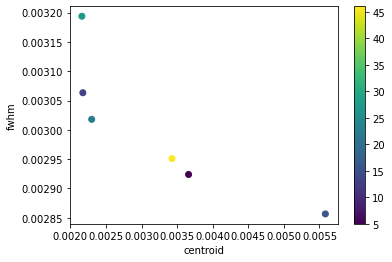

In [166]:
plt.scatter(xvals, yvals, c=idxs)
plt.xlabel('centroid')
plt.ylabel('fwhm')
plt.colorbar()

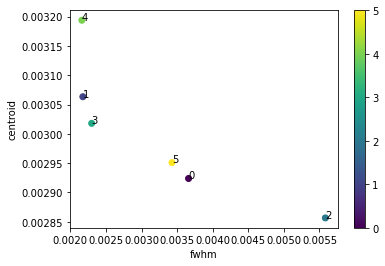

In [170]:
plt.scatter(xvals, yvals, c=np.arange(len(xvals)))
for i in range(len(xvals)):
    plt.annotate(str(i), (xvals[i], yvals[i]))
plt.xlabel('fwhm')
plt.ylabel('centroid')
plt.colorbar()

dict_values([-0.0005243003107627472, -0.005574122922444261, 0.013221518995996311, -0.0018174589560403624])


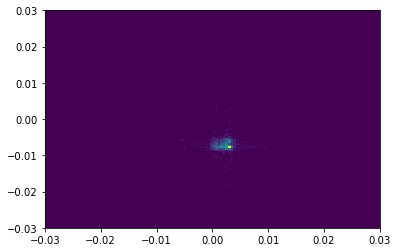

dict_values([0.004081688285810646, -0.02284282677965071, -0.0005572585922730966, -0.0036130958411006667])


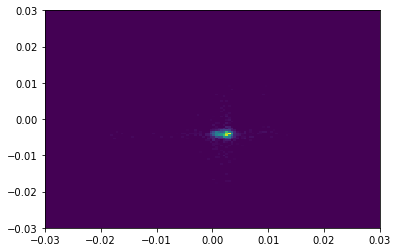

dict_values([0.003922744911349474, -0.02928483415986929, 0.009901742029053574, 0.006302790777368667])


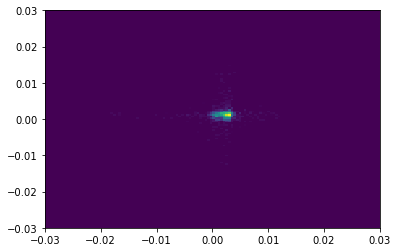

dict_values([-0.02087222376564675, -0.007962548761009717, 0.014220812340253876, -0.0004095105776632281])


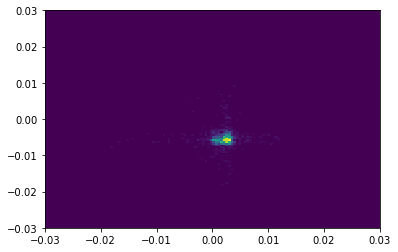

dict_values([-0.020024762040387997, -0.02424887703260218, 0.013633447293129573, -4.645610421173847e-05])


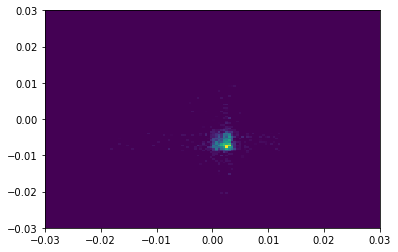

dict_values([0.0034871181528263046, -0.014744170863010327, 0.015570507452412386, 0.0023750842114649267])


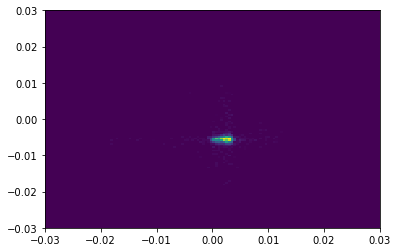

In [168]:
for pars in params:
    opt_trial1._lossfn_this(np.array(list(pars)))
    beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system=focusing_system, random_seed=DEFAULT_RANDOM_SEED, xrange=[-0.03, 0.03], yrange=[-0.03, 0.03], nbins=128)
    print(pars)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D)
    plt.show()

In [171]:
opt_trial1._lossfn_this(np.array(list(params[2])))

[0.002006740863803456, 0.00292173576549461]

In [172]:
opt_trial2 = OptunaOptimizer(focusing_system, 
                             motor_types=list(vkb_motors_ranges.keys()), 
                             random_seed=DEFAULT_RANDOM_SEED, 
                             loss_parameters=['centroid', 'sigma'],
                             loss_min_value=5e-4,
                             use_gaussian_fit=False)
opt_trial2.motor_ranges = np.array(list(vkb_motors_ranges.values()))
opt_trial2._lossfn_obj_this = opt_trial2.TrialInstanceLossFunction(opt_trial2, verbose=False)
opt_trial2._lossfn_this = opt_trial2._lossfn_obj_this.loss

In [173]:
study = optuna.create_study(directions=['minimize', 'minimize'])

[I 2022-09-10 16:39:34,325] A new study created in memory with name: no-name-a429082a-58fc-4fc0-b07b-69934e892cdc


In [174]:
study.optimize(opt_trial2.objective, n_trials=50)
#study.optimize(opt_trial2.objective, n_trials=10)

[I 2022-09-10 16:39:36,562] Trial 0 finished with values: [0.0020465901335605446, 0.003554471711068791] and parameters: {'vkb_1': -0.003606890869645416, 'vkb_2': -0.020445140785588806, 'vkb_3': -0.009840479792546599, 'vkb_4': -0.0043709483366646705}. 
[I 2022-09-10 16:39:38,807] Trial 1 finished with values: [0.01122058347385648, 0.004646366344384246] and parameters: {'vkb_1': 0.02921585969366413, 'vkb_2': 0.02831015052809774, 'vkb_3': -0.008109518073905916, 'vkb_4': 0.008265009393026447}. 
[I 2022-09-10 16:39:41,011] Trial 2 finished with values: [0.010295114026681231, 0.0030917729354450235] and parameters: {'vkb_1': 0.008365315444996031, 'vkb_2': -0.022787963784359027, 'vkb_3': -0.0060724241112613386, 'vkb_4': 0.007038389448269991}. 
[I 2022-09-10 16:39:43,222] Trial 3 finished with values: [0.0038500289482749145, 0.003012893253343143] and parameters: {'vkb_1': -0.0012752233824199141, 'vkb_2': 0.02975966173481477, 'vkb_3': 0.0001375455604189224, 'vkb_4': 0.0007665807845642011}. 
[I 2

In [175]:
trials = study.best_trials

In [176]:
trials

[FrozenTrial(number=7, values=[0.01103938945301552, 0.002868525329247299], datetime_start=datetime.datetime(2022, 9, 10, 16, 39, 50, 213003), datetime_complete=datetime.datetime(2022, 9, 10, 16, 39, 52, 425494), params={'vkb_1': -0.010216575896916914, 'vkb_2': 0.023222976456757374, 'vkb_3': -0.005526257464719521, 'vkb_4': 0.005576438631317744}, distributions={'vkb_1': UniformDistribution(high=0.03, low=-0.03), 'vkb_2': UniformDistribution(high=0.03, low=-0.03), 'vkb_3': UniformDistribution(high=0.02, low=-0.02), 'vkb_4': UniformDistribution(high=0.01, low=-0.01)}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, trial_id=7, state=TrialState.COMPLETE, value=None),
 FrozenTrial(number=24, values=[0.0019778451216804506, 0.002931886667586945], datetime_start=datetime.datetime(2022, 9, 10, 16, 40, 32, 348032), datetime_complete=datetime.datetime(2022, 9, 10, 16, 40, 34, 626343), params={'vkb_1': -0.013453010028365193, 'vkb_2': 0.023345035597937776, 'vkb_3': -0.00

In [177]:
xvals = []
yvals = []
idxs = []
params = []
for t in trials:
    xvals.append(t.values[0])
    yvals.append(t.values[1])
    idxs.append(t.number)
    params.append(t.params.values())
    

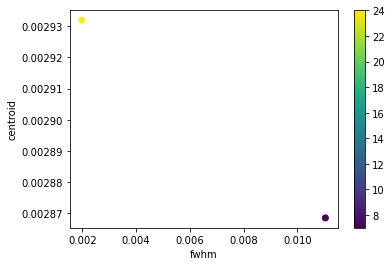

In [181]:
plt.scatter(xvals, yvals, c=idxs)
plt.xlabel('fwhm')
plt.ylabel('centroid')
plt.colorbar()

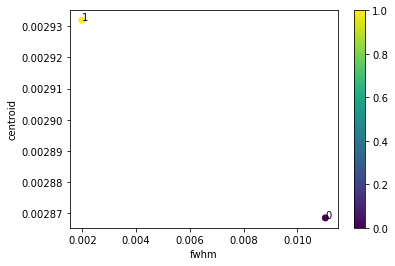

In [182]:
plt.scatter(xvals, yvals, c=np.arange(len(xvals)))
for i in range(len(xvals)):
    plt.annotate(str(i), (xvals[i], yvals[i]))
plt.xlabel('fwhm')
plt.ylabel('centroid')
plt.colorbar()

dict_values([-0.010216575896916914, 0.023222976456757374, -0.005526257464719521, 0.005576438631317744])


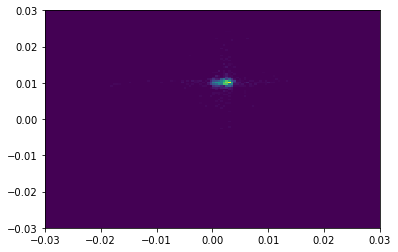

dict_values([-0.013453010028365193, 0.023345035597937776, -0.0009636450980520725, -0.002530817340571598])


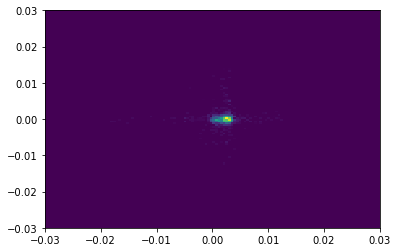

In [183]:
for pars in params:
    opt_trial2._lossfn_this(np.array(list(pars)))
    beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system=focusing_system, random_seed=DEFAULT_RANDOM_SEED, xrange=[-0.03, 0.03], yrange=[-0.03, 0.03], nbins=128)
    print(pars)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D)
    plt.show()